In [1]:
import os

import tensorflow as tf
import tensorflow_datasets as tfds

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import librosa
import librosa.display

In [75]:
ds, info = tfds.load(name='nsynth',
                     download=False,
                     split='train',
                     try_gcs=True,
                     data_dir='/home/dadmaan/Seagate Backup Plus Drive/datasets/nsynth',
                     with_info=True)

In [3]:
info.features

FeaturesDict({
    'audio': Tensor(shape=(64000,), dtype=tf.float32),
    'id': tf.string,
    'instrument': FeaturesDict({
        'family': ClassLabel(shape=(), dtype=tf.int64, num_classes=11),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=1006),
        'source': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    'pitch': ClassLabel(shape=(), dtype=tf.int64, num_classes=128),
    'qualities': FeaturesDict({
        'bright': tf.bool,
        'dark': tf.bool,
        'distortion': tf.bool,
        'fast_decay': tf.bool,
        'long_release': tf.bool,
        'multiphonic': tf.bool,
        'nonlinear_env': tf.bool,
        'percussive': tf.bool,
        'reverb': tf.bool,
        'tempo-synced': tf.bool,
    }),
    'velocity': ClassLabel(shape=(), dtype=tf.int64, num_classes=128),
})

In [4]:
print(info.features["instrument"]['family'].num_classes)
print(info.features["instrument"]['family'].names)

11
['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']


In [5]:
print(info.features["instrument"]['family'].int2str(0))
print(info.features["instrument"]['family'].str2int('bass'))

bass
0


In [6]:
print(info.features["instrument"]['label'].num_classes)
# print(info.features["instrument"]['label'].names)

1006


In [7]:
print(info.splits['valid[:80%]'].num_examples)
print(info.splits['valid[80%:90%]'].num_examples)
print(info.splits['valid[90%:]'].num_examples)

10142
1268
1268


In [7]:
for example in ds:
    print(list(example.keys()))
    audio = example['audio']
    a_id = example['id']
    instrument = example['instrument']
    pitch = example['pitch']

['audio', 'id', 'instrument', 'pitch', 'qualities', 'velocity']


## Training dataset Instruments

In [143]:
ds_instrument = ds.map(lambda x: (x['audio'], x['instrument']['family']))

In [144]:
y = []
for audio, feature in ds_instrument:
    y.append(feature.numpy())

In [145]:
instruments = {}
for i in range(0, 11):
    instrument_name = info.features["instrument"]['family'].int2str(i)
    n_instrument = y.count(i)
    entry = { instrument_name : n_instrument }
    instruments.update(entry)

In [146]:
instruments

{'bass': 65474,
 'brass': 12675,
 'flute': 8773,
 'guitar': 32690,
 'keyboard': 51821,
 'mallet': 34201,
 'organ': 34477,
 'reed': 13911,
 'string': 19474,
 'synth_lead': 5501,
 'vocal': 10208}

In [147]:
train_instrument = pd.DataFrame.from_dict(instruments, orient='index', columns=['Training'])

## Validation dataset Instruments

In [98]:
instruments = {}
for i in range(0, 11):
    instrument_name = info.features["instrument"]['family'].int2str(i)
    n_instrument = y.count(i)
    entry = { instrument_name : n_instrument }
    instruments.update(entry)

In [101]:
instruments

{'bass': 2638,
 'brass': 886,
 'flute': 470,
 'guitar': 2081,
 'keyboard': 2404,
 'mallet': 663,
 'organ': 1598,
 'reed': 720,
 'string': 814,
 'synth_lead': 0,
 'vocal': 404}

In [128]:
valid_instrument = pd.DataFrame.from_dict(instruments, orient='index', columns=['Validation'])

In [74]:
train_instrument.loc[:,'Validation'] = pd.Series(valid_instrument['Validation'], 
                                                    index=train_instrument.index)
train_instrument.to_latex('nsynth/nsynth_dataset_instrument.txt', index=True)

## NSynth dataset plots

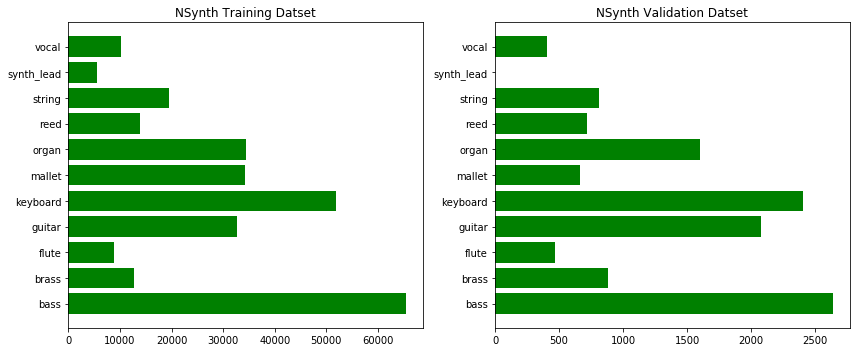

In [59]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.barh(df1.index, df1['number of instruments'], color='g')
plt.title('NSynth Training Datset')

plt.subplot(1,2,2)
plt.barh(valid_instrument.index, valid_instrument['number of instruments'], color='g')
plt.title('NSynth Validation Datset')

plt.tight_layout()
plt.savefig('nsynth/nsynth_dataset_instrument_distribution.png')
plt.show()

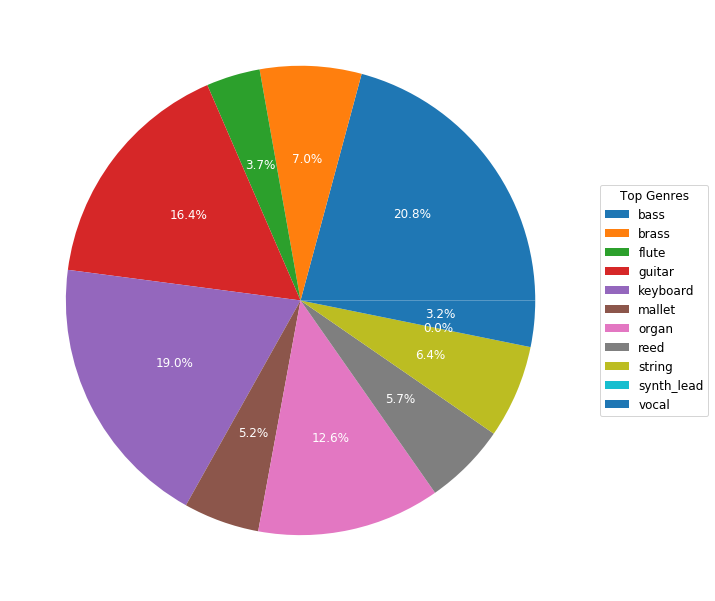

In [163]:
series = pd.Series(df['number of instruments'], index=df.index, name='series')
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)


wedges, texts, autotexts = ax.pie(series, autopct=lambda pct: func(pct, series),
                                  textprops=dict(color="w"))

ax.legend(wedges, series.index,
          title="Top Genres",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.savefig('fma/pie_chart_top_genre.png')

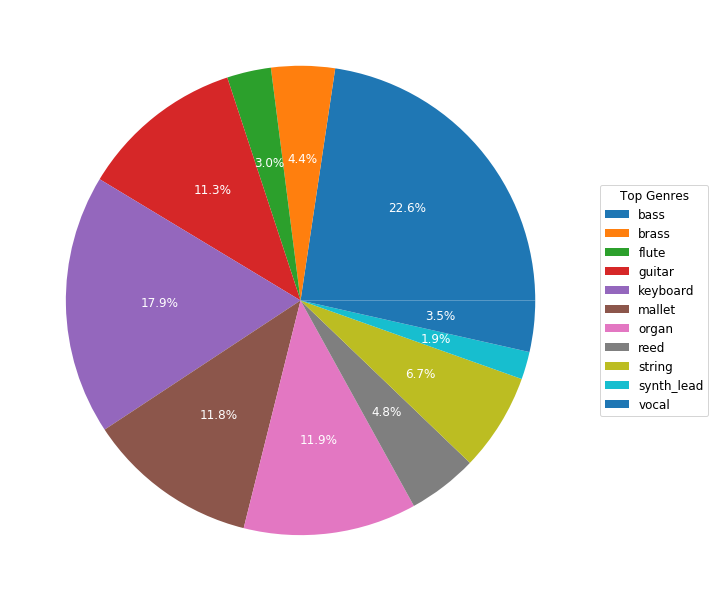

In [164]:
series = pd.Series(dft['number of instruments'], index=df.index, name='series')
plt.rcParams['font.size'] = 12
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)


wedges, texts, autotexts = ax.pie(series, autopct=lambda pct: func(pct, series),
                                  textprops=dict(color="w"))

ax.legend(wedges, series.index,
          title="Top Genres",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.savefig('fma/pie_chart_top_genre.png')

## Audio Files

In [78]:
import json
import pandas as pd


path = r"/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/examples.json"
file = open(path)
json_file = json.load(file)
level = 4
#don't have to put the column names, but it will make the excel in nicer order
df = pd.DataFrame(columns = ["key0", "dt0", "key1", "dt1", "key2", "dt2", "key3", "dt3", "key4", "dt4"])
def parse_json(key, value,curent_level,massage):
    global df
    global level
    if curent_level == level:
        df = df.append(massage,ignore_index = True)
        return
    t = type(value)
    if t == str:
        try:
            tmp = json.loads(value)
            massage["key"+str(curent_level)] = key
            massage["dt"+str(curent_level)] = "json"
            for k in tmp:
                parse_json(k,tmp[k],curent_level+1,massage)
        except:
            massage["key"+str(curent_level)] = key
            massage["dt"+str(curent_level)] = "str"
            df = df.append(massage,ignore_index = True)
            return
    else:
        if t == list:
            massage["key"+str(curent_level)] = key
            massage["dt"+str(curent_level)] = "list"
            for li in value:
                parse_json(key,li,curent_level+1,massage)
        if t == dict:
            massage["key"+str(curent_level)] = key
            massage["dt"+str(curent_level)] = "dict"
            for k in value:
                parse_json(k,value[k],curent_level+1,massage)
        if t == set:
            massage["key"+str(curent_level)] = key
            massage["dt"+str(curent_level)] = "set"
            for li in value:
                parse_json(key,li,curent_level+1,massage)

        massage["key"+str(curent_level)] = key
        massage["dt"+str(curent_level)] = "simple"
        df = df.append(massage,ignore_index = True)


parse_json("json_file", json_file,0,{})
df.to_csv(r"/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/examples.csv")

KeyboardInterrupt: 

In [81]:
bass = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/bass_electronic_018-022-025.wav'
brass = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/brass_acoustic_006-024-025.wav'
flute = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/flute_acoustic_002-067-075.wav'
keyboard = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/keyboard_acoustic_004-021-025.wav'
guitar = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/guitar_acoustic_010-021-025.wav'
mallet = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/mallet_acoustic_047-065-050.wav'
organ = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/organ_electronic_001-036-025.wav'
reed = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/reed_acoustic_011-035-025.wav'
string = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/string_acoustic_012-024-025.wav'
vocal = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/nsynth_wav/nsynth-valid/audio/vocal_acoustic_000-050-075.wav'

In [82]:
x1, sr1 = librosa.load(bass, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x2, sr2 = librosa.load(brass, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x3, sr3 = librosa.load(flute, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x4, sr4 = librosa.load(keyboard, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x5, sr5 = librosa.load(guitar, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x6, sr6 = librosa.load(mallet, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x7, sr7 = librosa.load(organ, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x8, sr8 = librosa.load(reed, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x9, sr9 = librosa.load(string, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

x10, sr10 = librosa.load(vocal, sr=None, mono=True)
# print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))
# start, end = 0, 5
# ipd.Audio(data=x[start*sr:end*sr], rate=sr)

In [84]:
cqt1 = np.abs(librosa.cqt(x1, sr=sr1))
cqt2 = np.abs(librosa.cqt(x2, sr=sr2))
cqt3 = np.abs(librosa.cqt(x3, sr=sr3))
cqt4 = np.abs(librosa.cqt(x4, sr=sr4))
cqt5 = np.abs(librosa.cqt(x5, sr=sr5))
cqt6 = np.abs(librosa.cqt(x6, sr=sr6))
cqt7 = np.abs(librosa.cqt(x7, sr=sr7))
cqt8 = np.abs(librosa.cqt(x8, sr=sr8))
cqt9 = np.abs(librosa.cqt(x9, sr=sr9))
cqt10 = np.abs(librosa.cqt(x10, sr=sr10))

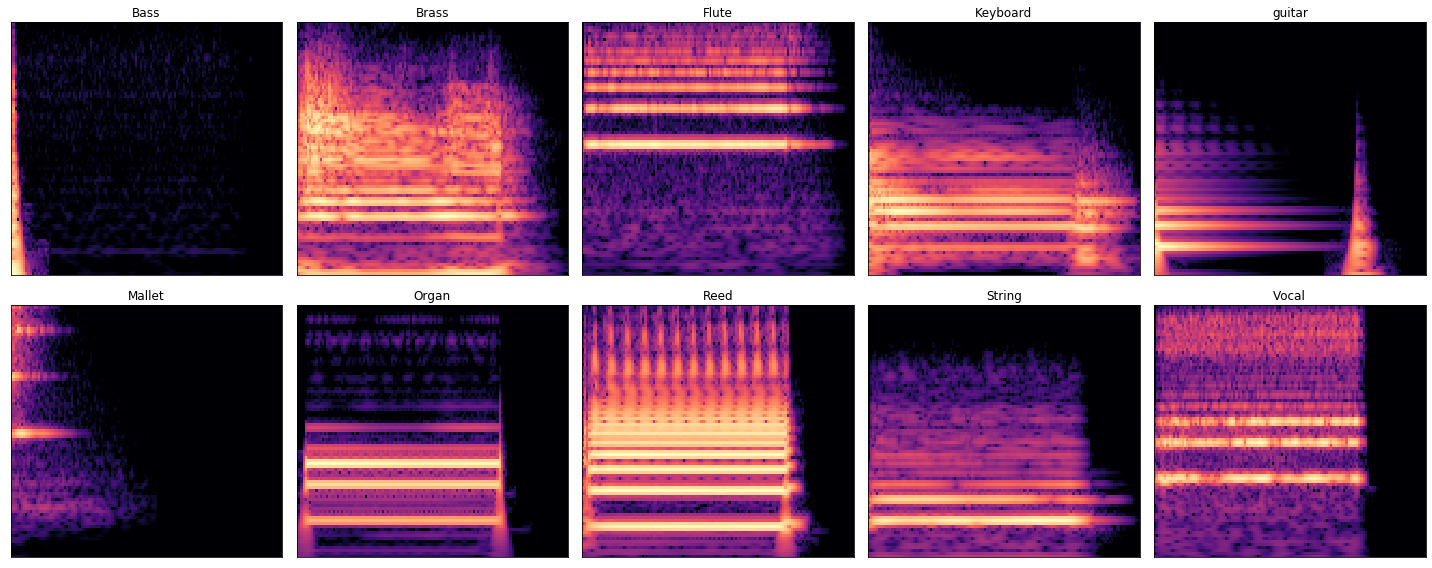

In [88]:
fig = plt.figure(figsize=(20,8))
row = 2
column = 5
plt.subplot(row,column,1)
librosa.display.specshow(librosa.amplitude_to_db(cqt1, ref=np.max), sr=sr1)
plt.title('Bass')

plt.subplot(row,column,2)
librosa.display.specshow(librosa.amplitude_to_db(cqt2, ref=np.max), sr=sr2)
plt.title('Brass')

plt.subplot(row,column,3)
librosa.display.specshow(librosa.amplitude_to_db(cqt3, ref=np.max), sr=sr3)
plt.title('Flute')

plt.subplot(row,column,4)
librosa.display.specshow(librosa.amplitude_to_db(cqt4, ref=np.max), sr=sr4)
plt.title('Keyboard')

plt.subplot(row,column,5)
librosa.display.specshow(librosa.amplitude_to_db(cqt5, ref=np.max), sr=sr5)
plt.title('guitar')

plt.subplot(row,column,6)
librosa.display.specshow(librosa.amplitude_to_db(cqt6, ref=np.max), sr=sr6)
plt.title('Mallet')

plt.subplot(row,column,7)
librosa.display.specshow(librosa.amplitude_to_db(cqt7, ref=np.max), sr=sr7)
plt.title('Organ')

plt.subplot(row,column,8)
librosa.display.specshow(librosa.amplitude_to_db(cqt8, ref=np.max), sr=sr8)
plt.title('Reed')

plt.subplot(row,column,9)
librosa.display.specshow(librosa.amplitude_to_db(cqt9, ref=np.max), sr=sr9)
plt.title('String')

plt.subplot(row,column,10)
librosa.display.specshow(librosa.amplitude_to_db(cqt10, ref=np.max), sr=sr10)
plt.title('Vocal')

plt.tight_layout()
plt.savefig('nsynth/instruments_spectrogram_sample.png')